In [41]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
import sys
sys.path.append("../")
import read_mist_models
from matplotlib import colors
from scipy.interpolate import interp1d
import utils

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=20)
pl.rc('axes', titlesize=30)

%matplotlib inline

In [16]:
mpl.matplotlib_fname()

'/Users/tgordon/.matplotlib/matplotlibrc'

In [4]:
data = utils.read_round("../output/out.dat")

# load in Kepler-Gaia crossmatch
k2dr2 = Table.read('../k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic_number')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# read in MIST isochrone
iso = read_mist_models.ISOCMD('../MIST_iso_5da0dbfba0a60.iso.cmd')
mist = iso.isocmds[iso.age_index(9.0)]
# read in parsec isochrones for converting to B-V color 
isonames1 = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')
parsec1 = pd.read_table('../output783328222883.dat', delim_whitespace=True, header=None, comment='#', names=isonames1)
isonames2 = ('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 
             'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
             'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag')
parsec2 = pd.read_table('../output632510793236.dat', delim_whitespace=True, header=None, comment='#', names=isonames2)
iok = np.where((parsec1['label'] < 2) & (parsec1['Gmag'] > 1.7))[0][::-1]

Reading in: ../MIST_iso_5da0dbfba0a60.iso.cmd


Text(0.5,1,'$10^9$ yr isochrone')

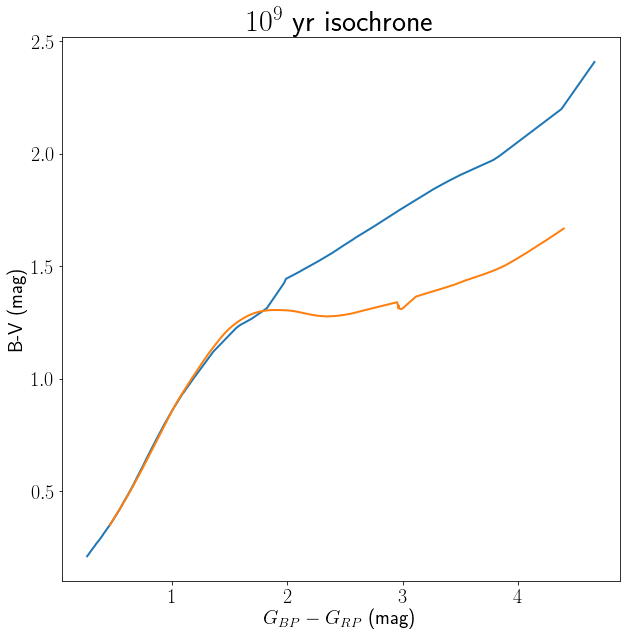

In [42]:
pl.figure(figsize=(10,10))
pl.plot(parsec1['G_BPmag'][iok] - parsec1['G_RPmag'][iok], parsec2['Bmag'][iok] - parsec2['Vmag'][iok])

m2b = np.where((mist['Gaia_G_DR2Rev'] > 2) & (mist['Gaia_BP_DR2Rev'] - mist['Gaia_RP_DR2Rev'] > 0))[0][::-1]
pl.plot(mist['Gaia_BP_DR2Rev'][m2b] - mist['Gaia_RP_DR2Rev'][m2b], mist['Bessell_B'][m2b] - mist['Bessell_V'][m2b])

pl.xlabel('$G_{BP} - G_{RP}$ (mag)')
pl.ylabel('B-V (mag)')
pl.title('$10^9$ yr isochrone')

In [43]:
# select stars with good gaia results 

good_parallax = df["parallax_error"] < 0.1
unimodal_distance_result = (df["r_modality_flag"] == 1) & (df["r_result_flag"] == 1)
has_finite_bp_rp = np.isfinite(df["bp_rp"])
good_bp = df["phot_bp_mean_flux_error"]/df[u'phot_bp_mean_flux'] < 0.01
good_rp = df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01
good_mg = df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01
in_r_range = df["r_est"] < 1000
mask = good_parallax & unimodal_distance_result & has_finite_bp_rp & good_bp & good_rp & good_mg & in_r_range

In [44]:
# interpolate to get mg along isochrone for each star

iso_bp_rp = mist['Gaia_BP_MAWb'] - mist['Gaia_RP_MAW']
iso_mg = mist['Gaia_G_MAW']
mass_mask = (mist['initial_mass'] < 2.0) & (mist['initial_mass'] > 0.2)
iso_bp_rp = iso_bp_rp[mass_mask]
iso_mg = iso_mg[mass_mask]

in_color_range = (df["bp_rp"] > min(iso_bp_rp)) & (df["bp_rp"] < max(iso_bp_rp))
mask = mask & in_color_range

interpolator = interp1d(iso_bp_rp, iso_mg)
iso_mg_interp = interpolator(df[mask]['bp_rp'])

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


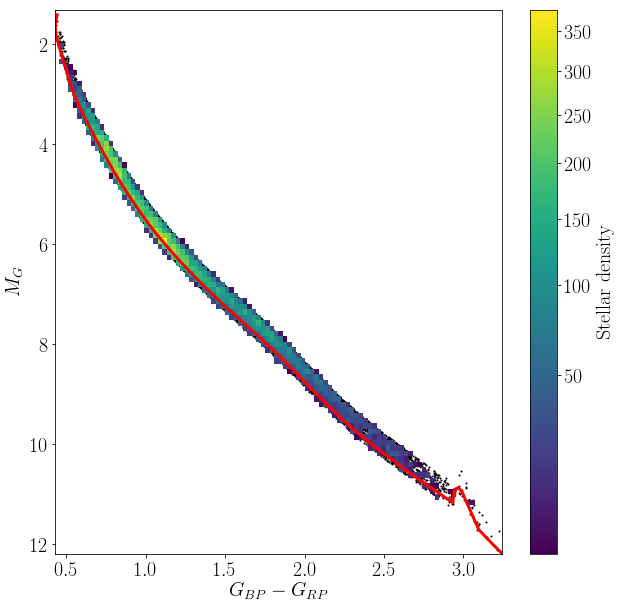

In [46]:
correction = 5*np.log10(df[mask]["r_est"])-5 # get absolute mag Mg from relative mg by applying distance correction 
bp_rp, mg = np.array(df[mask]["bp_rp"]), np.array(df[mask]["phot_g_mean_mag"])-correction
is_ms = (mg - iso_mg_interp < 0.1) & (iso_mg_interp - mg < 0.4)

fig, ax = pl.subplots(figsize=(10, 10))

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[is_ms], mg[is_ms], bins=100, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter
ax.scatter(bp_rp[is_ms], mg[is_ms], alpha=1, s=1, color='k', zorder=0)
ax.plot(iso_bp_rp, iso_mg, 'r', linewidth=3) 
ax.invert_yaxis()
cb = fig.colorbar(h[3])
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
pl.show()

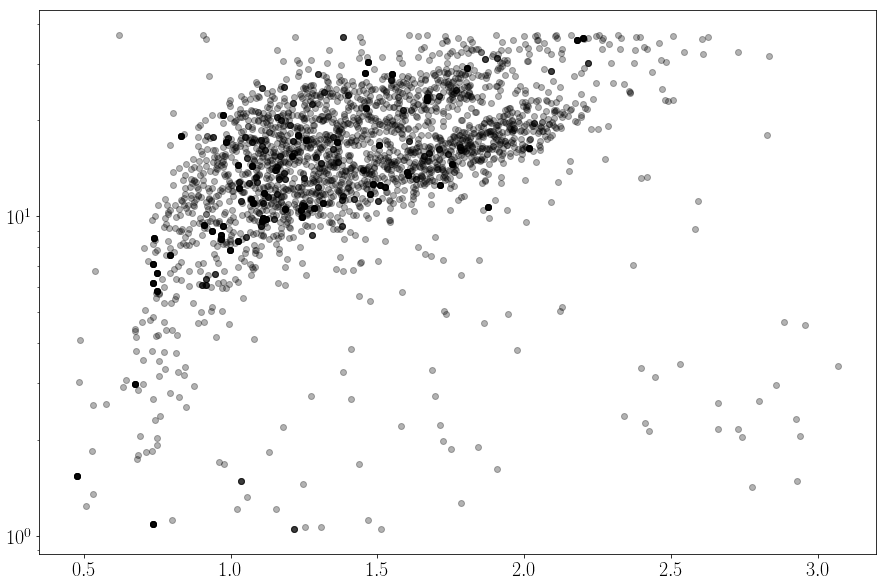

In [47]:
relative_uncertainty = df['logperiod_sd']/df['logperiod_mean']
good_period = (df['logperiod_neff'] > 6000) & (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1) & (relative_uncertainty < 0.02) & (np.exp(df['logperiod_mean']) < 37)
period = np.exp(df[mask & is_ms & good_period]['logperiod_mean'])
color = df[mask & is_ms & good_period]['bp_rp']
fig = pl.figure(figsize=(15, 10))
pl.semilogy(color, period, 'o', alpha=0.3, color='k')

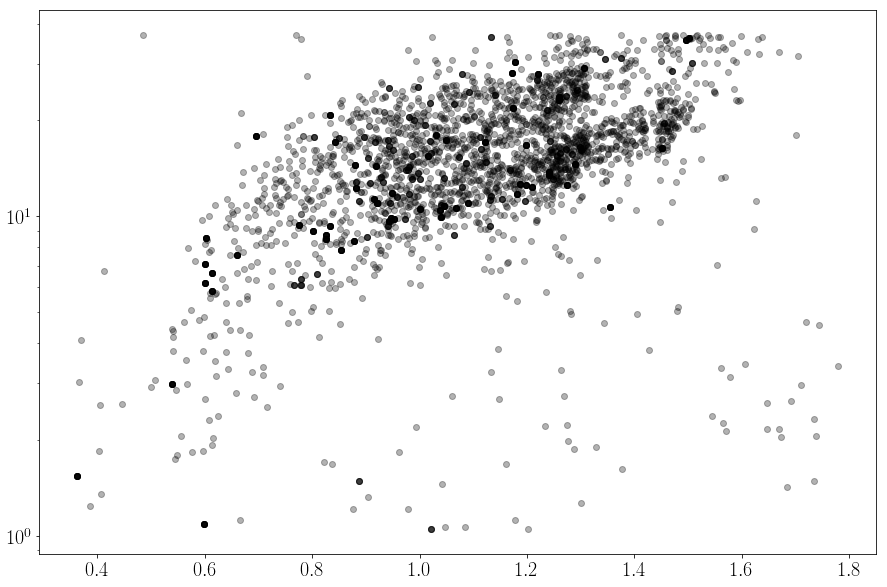

In [50]:
relative_uncertainty = df['logperiod_sd']/df['logperiod_mean']
good_period = (df['logperiod_neff'] > 6000) & (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1) & (relative_uncertainty < 0.02) & (np.exp(df['logperiod_mean']) < 37)
period = np.exp(df[mask & is_ms & good_period]['logperiod_mean'])
BV_ms = np.interp(df[mask & is_ms & good_period]['bp_rp'], parsec1['G_BPmag'][iok] - parsec1['G_RPmag'][iok],
                 parsec2['Bmag'][iok] - parsec2['Vmag'][iok])
fig = pl.figure(figsize=(15, 10))
pl.semilogy(BV_ms, period, 'o', alpha=0.3, color='k')

In [51]:
# gyrochrones 

def MM09e2(B_V, age):
    ''' 
    Eqn 2 
    http://adsabs.harvard.edu/abs/2009ApJ...695..679M
    '''
    a = 0.50
    b = 0.15
    P = np.sqrt(age) * (np.sqrt(B_V - a)) - b * (B_V - a)
    return P

def MM09e3(B_V, age):
    ''' Eqn 3 '''
    c = 0.77
    d = 0.40
    f = 0.60
    P = age**0.52 * (c * (B_V - d)**f)
    return P

def MH2008(B_V, age):
    '''
    Equations 12,13,14 from Mamajek & Hillenbrand (2008)
    http://adsabs.harvard.edu/abs/2008ApJ...687.1264M

    Coefficients from Table 10
    
    Parameters
    ----------
    B_V (B-V) color
    age in Myr

    Returns
    -------
    period in color

    '''
    a = 0.407
    b = 0.325
    c = 0.495
    n = 0.566

    f = a * np.power(B_V - c, b)
    g = np.power(age, n)

    P = f * g

    return P


def Angus2015(B_V, age):
    '''
    Compute the rotation period expected for a star of a given color (temp) and age

    NOTE: - input Age is in MYr
          - output Period is in days

    Eqn 15 from Angus+2015
    http://adsabs.harvard.edu/abs/2015MNRAS.450.1787A

    '''
    P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)

    return P

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


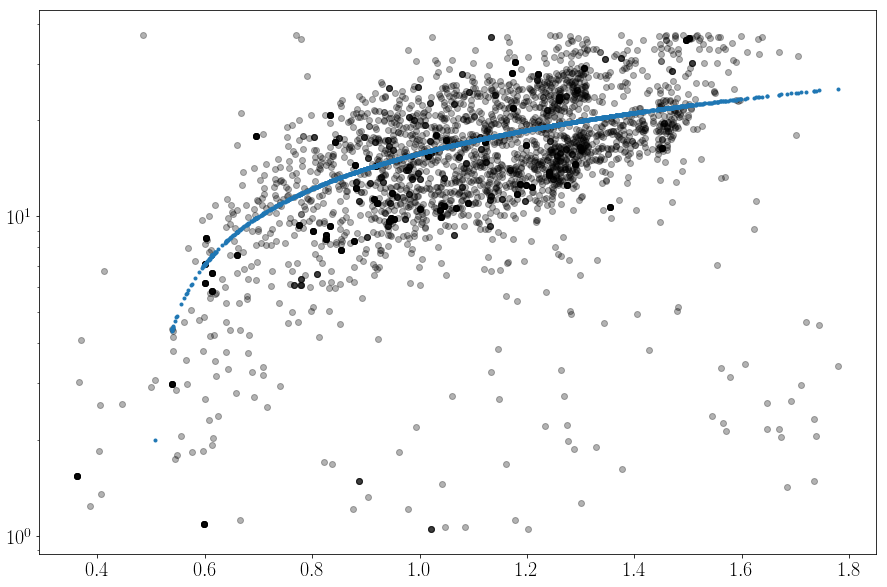

In [76]:
fig = pl.figure(figsize=(15, 10))
pl.semilogy(BV_ms, period, 'o', alpha=0.3, color='k')
pl.semilogy(BV_ms, MM09e2(BV_ms, 500), '.')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


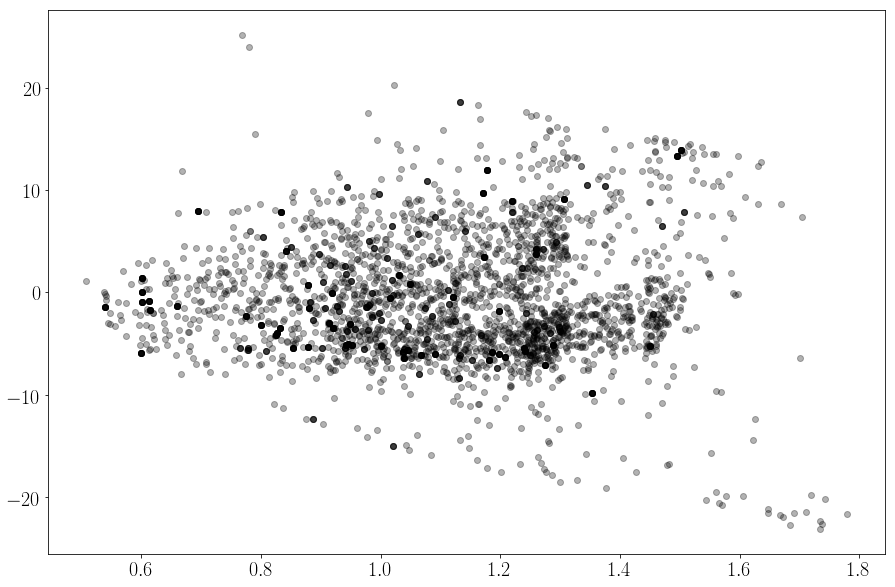

In [71]:
fig = pl.figure(figsize=(15, 10))
pl.plot(BV_ms, period - MM09e2(BV_ms, 500), 'o', alpha=0.3, color='k')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


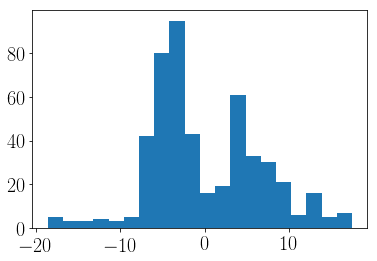

In [80]:
BV_mask = (BV_ms > 1.25) & (BV_ms < 1.35)
pl.hist(period[BV_mask] - MM09e2(BV_ms, 500)[BV_mask], bins=20);